In [1]:
import os

In [2]:
os.getenv("PATH")

'/cluster/project/treutlein/jjans/software/miniforge3/envs/chrombpnet2/bin:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/bin:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/bin:/cluster/apps/gcc-8.2.0/cuda-12.1.1-mpwcqkwqghc7y2at5a6wuuhbgmm6efux/bin:/cluster/apps/gcc-8.2.0/openblas-0.3.15-huwxbhezdzoo74awrgoz6sd2qndpmdva/bin:/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/bin:/cluster/apps/gcc-8.2.0/eccodes-2.21.0-o4xitaateyj4fuopb6chuxme7d5bp4zp/bin:/cluster/apps/gcc-8.2.0/hdf5-1.10.1-qj3ju3qfhvucsk5eevrtb2lehbux5nmv/bin:/cluster/apps/nss/jupyterhub/3.5.1/bin:/cluster/apps/gcc-8.2.0/git-2.31.1-q45wg6avfyvko4weuhmnpghaag45ynoo/bin:/cluster/apps/gcc-8.2.0/npm-6.14.9-774crfohwvu6a33ijcow7x5cvonu44oi/bin:/cluster/apps/gcc-8.2.0/r-4.2.2-ydfaklhfrhw5dy6qcfzxlxfviwovcord/bin:/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vprec3fs/bin:/cluster/apps/local:/cluster/apps/sfos/bin:/usr/local/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/sbin:/bin:/cluster/slurm/

In [3]:
os.getenv("LD_LIBRARY_PATH")

'/cluster/project/treutlein/jjans/software/miniforge3/envs/cuda11_env/lib:/cluster/project/treutlein/jjans/software/miniforge3/envs/chrompbnet2/lib:/cluster/project/treutlein/jjans/software/miniforge3/envs/chrompbnet/lib:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib:/cluster/apps/gcc-8.2.0/cudnn-8.9.2.26-ogi7ed2h6ejs7vumekv46idqqas4axgq/lib:/cluster/apps/gcc-8.2.0/cuda-12.1.1-mpwcqkwqghc7y2at5a6wuuhbgmm6efux/lib64:/cluster/apps/gcc-8.2.0/nccl-2.11.4-1-pwkiz23vbeac3vt5ykybdwzaykprizb2/lib:/cluster/apps/gcc-8.2.0/openblas-0.3.15-huwxbhezdzoo74awrgoz6sd2qndpmdva/lib:/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64:/cluster/apps/gcc-8.2.0/zlib-1.2.9-roj3c3p7lbd2kn3gstlt4rxdcgvb3csi/lib:/cluster/apps/gcc-8.2.0/eccodes-2.21.0-o4xitaateyj4fuopb6chuxme7d5bp4zp/lib64:/cluster/apps/gcc-8.2.0/hdf5-1.10.1-qj3ju3qfhvucsk5eevrtb2lehbux5nmv/lib:/cluster/apps/gcc-8.2.0/npm-6.14.9-774crfohwvu6a33ijcow7x5cvonu44oi/lib:/cluster/apps/gcc-8.2.

In [4]:
# Adapted from chrombpnet-lite

import deepdish as dd
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import shap
import pyfaidx
import shutil
import errno
import os


In [5]:
import argparse
import chrombpnet.evaluation.interpret.shap_utils as shap_utils
import chrombpnet.evaluation.interpret.input_utils as input_utils

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]


In [6]:
# disable eager execution so shap deep explainer wont break
tf.compat.v1.disable_eager_execution()


In [7]:
def fetch_interpret_args():
    parser = argparse.ArgumentParser(description="get sequence contribution scores for the model")
    parser.add_argument("-g", "--genome", type=str, required=True, help="Genome fasta")
    parser.add_argument("-r", "--regions", type=str, required=True, help="10 column bed file of peaks. Sequences and labels will be extracted centered at start (2nd col) + summit (10th col).")
    parser.add_argument("-m", "--model_h5", type=str, required=True, help="Path to trained model, can be both bias or chrombpnet model")
    parser.add_argument("-o", "--output-prefix", type=str, required=True, help="Output prefix")
    parser.add_argument("-d", "--debug_chr", nargs="+", type=str, default=None, help="Run for specific chromosomes only (e.g. chr1 chr2) for debugging")
    parser.add_argument("-p", "--profile_or_counts", nargs="+", type=str, default=["counts", "profile"], choices=["counts", "profile"],
                        help="use either counts or profile or both for running shap")

    args = parser.parse_args()
    return args


In [8]:
def generate_shap_dict(seqs, scores):
    assert(seqs.shape==scores.shape)
    assert(seqs.shape[2]==4)

    # construct a dictionary for the raw shap scores and the
    # the projected shap scores
    # MODISCO workflow expects one hot sequences with shape (None,4,inputlen)
    d = {
            'raw': {'seq': np.transpose(seqs, (0, 2, 1)).astype(np.int8)},
            'shap': {'seq': np.transpose(scores, (0, 2, 1)).astype(np.float16)},
            'projected_shap': {'seq': np.transpose(seqs*scores, (0, 2, 1)).astype(np.float16)}
        }

    return d


In [36]:
def interpret(model, seqs, output_prefix, profile_or_counts,save_files=True):
    print("Seqs dimension : {}".format(seqs.shape))

    outlen = model.output_shape[0][1]

    profile_model_input = model.input
    profile_input = seqs
    counts_model_input = model.input
    counts_input = seqs

    if "counts" in profile_or_counts:
        profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
            (counts_model_input, tf.reduce_sum(model.outputs[1], axis=-1)),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'counts' shap scores")
        counts_shap_scores = profile_model_counts_explainer.shap_values(
            counts_input, progress_message=100)

        counts_scores_dict = generate_shap_dict(seqs, counts_shap_scores)

        if save_files:
            # save the dictionary in HDF5 formnat
            print("Saving 'counts' scores")

            dd.io.save("{}.counts_scores.h5".format(output_prefix),
                        counts_scores_dict,
                        compression='blosc')

#            del counts_shap_scores, counts_scores_dict

    if "profile" in profile_or_counts:
        weightedsum_meannormed_logits = shap_utils.get_weightedsum_meannormed_logits(model)
        profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
            (profile_model_input, weightedsum_meannormed_logits),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'profile' shap scores")
        profile_shap_scores = profile_model_profile_explainer.shap_values(
            profile_input, progress_message=100)

        profile_scores_dict = generate_shap_dict(seqs, profile_shap_scores)

        if save_files:
            # save the dictionary in HDF5 formnat
            print("Saving 'profile' scores")
            dd.io.save("{}.profile_scores.h5".format(output_prefix),
                        profile_scores_dict,
                        compression='blosc')
    
    results = {}
    results['profile'] = ''
    results['counts_scores'] = ''
    results['counts_shap'] = ''
    if "profile" in profile_or_counts:
        results['profile'] = profile_scores_dict
    if "counts" in profile_or_counts:
        results['counts_scores'] = counts_scores_dict
        results['counts_shap'] = counts_shap_scores

    return(results)


In [10]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

regions_df = pd.read_csv("regions_of_interest/SLC5A12_regions_peaks.bed", sep='\t', names=NARROWPEAK_SCHEMA)


In [11]:
regions_df

,chr,start,end,1,2,3,4,5,6,summit
0,chr11,26717818,26718316,human_peaks_peak_14180,76,.,3.22261,9.79667,7.69159,133
1,chr11,26734626,26735026,human_peaks_peak_14184,137,.,4.69416,16.03900,13.74490,286


In [12]:
import os
import sys
import os
import sys
import tensorflow as tf
import numpy as np
import chrombpnet.training.utils.losses as losses
from chrombpnet.training.utils.data_utils import one_hot
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model


def get_seq(peaks_df, genome, width):
    """
    Same as get_cts, but fetches sequence from a given genome.
    """
    vals = []
    peaks_used = []
    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
            vals.append(sequence)
            peaks_used.append(True)
        else:
            peaks_used.append(False)

    return one_hot.dna_to_one_hot(vals), np.array(peaks_used)



In [13]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

got the model
got the model
got the model
got the model
got the model


In [14]:
# infer input length
inputlen = model.input_shape[1] # if bias model (1 input only)
print("inferred model inputlen: ", inputlen)


inferred model inputlen:  2114


In [15]:
genome_path = 'encode_data/hg38.fa'

#region 0 contains the human chimp divergent SNCs

import pyfaidx
genome_path = 'encode_data/hg38.fa'
genome = pyfaidx.Fasta(genome_path)
width = input_len = inputlen
chrom='chr11'
start,end = 26717818,26718316
summit = 133

start_use = int(start+summit - input_len/2)+1
end_use = int(start + summit + input_len/2)

middle = int((start+end)/2)
nstart = middle-int(input_len/2)
nend = nstart + input_len

#fasta format
seq_man = genome.get_seq(chrom,start_use,end_use)

#string
seq_man2 = str(genome[chrom][(start_use-1):(end_use)])


sequence = seq_man2
vals = []
if len(sequence) == width:
    vals.append(sequence)


In [16]:
human_SNCs = pd.read_csv("extra_data/hg38_panTro6_SLC5A12i_divergent_site.tsv",sep="\t")
human_SNCs['d_start'] = human_SNCs['hg38_coor(1-based)']-start_use
human_SNCs['d_start_match'] = [sequence[x] for x in human_SNCs['d_start']]
human_SNCs = human_SNCs.reset_index()
human_SNCs['ID'] = 'ID_'+human_SNCs['index'].astype('str')

In [17]:
def evo_seq(sequence,position,ref,alt):
    if sequence[position]==ref:
        mod_seq = sequence[:position] + alt + sequence[position + 1:]
    else:
        print("reference does not occur at position, double check position")
        mod_seq = None
    return(mod_seq)

def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)



In [18]:
def generate_binary_combinations(num_bits):
    num_combinations = 2 ** num_bits
    format_string = f'{{:0{num_bits}b}}'
    combinations = []
    for i in range(num_combinations):
        binary_string = format_string.format(i)
        combinations.append([int(bit) for bit in binary_string])
    return combinations

# Example usage for 12 binary variables
num_variables = len(human_SNCs.index)
combinations = generate_binary_combinations(num_variables)

In [19]:
all_mutated_sequences = []
all_mutated_sequences_df = []
i = 0
ref_sequences = []

for comb in combinations:
    positions = np.where(np.array(comb) == 1)[0]
    human_SNCs_comb = human_SNCs.iloc[positions].copy()

#    if len(human_SNCs_comb.index)==0:
#        comb_sequence = sequence

    comb_sequence = sequence
    
    for SNC in human_SNCs_comb.index:
        position,ref,alt = human_SNCs_comb.loc[SNC,'d_start'],human_SNCs_comb.loc[SNC,'Hg38'],human_SNCs_comb.loc[SNC,'panTro6']

        comb_sequence = evo_seq(comb_sequence,position,ref,alt)

    
    all_mutated_sequences.append(comb_sequence)
    ref_sequences.append(sequence)
    
    concatenated_ids = "_".join(human_SNCs_comb['ID'])
    total_mutations = np.sum(comb)
    
    all_mutated_sequences_df.append(dict(sequence_id=i,ntot=total_mutations,SNC=concatenated_ids))
    i+=1

In [20]:
all_mutated_sequences_df = pd.DataFrame(all_mutated_sequences_df)
all_mutated_sequences_ohe = one_hot.dna_to_one_hot(all_mutated_sequences)
ref_sequences_ohe = one_hot.dna_to_one_hot(ref_sequences)

In [22]:
#ref_batch_preds = model.predict(ref_sequences_ohe)


In [23]:
import time

In [24]:
import random
random.seed(42)

In [25]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    print(fold)
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

    ref_logcount_preds=[]
    alt_logcount_preds=[]
    ref_prob_preds=[]
    alt_prob_preds=[]

    print("predict reference sequence")
    ref_batch_preds = model.predict(ref_sequences_ohe)
    time.sleep(5)

    print("predict mutations sequence")
    alt_batch_preds = model.predict(all_mutated_sequences_ohe)
    time.sleep(5)

    ref_logcount_preds.extend(np.squeeze(ref_batch_preds[1]))
    alt_logcount_preds.extend(np.squeeze(alt_batch_preds[1]))
    
    ref_prob_preds.extend(np.squeeze(softmax(ref_batch_preds[0])))
    alt_prob_preds.extend(np.squeeze(softmax(alt_batch_preds[0])))

    ref_logcount_preds = np.array(ref_logcount_preds)
    alt_logcount_preds = np.array(alt_logcount_preds)
    ref_prob_preds = np.array(ref_prob_preds)
    alt_prob_preds = np.array(alt_prob_preds)

    from scipy.spatial.distance import jensenshannon
    
    log_counts_diff = alt_logcount_preds - ref_logcount_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)*np.sign(log_counts_diff)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])*np.sign(log_counts_diff)

    all_mutated_sequences_df[fold+'--logcount_preds'] = alt_logcount_preds
    all_mutated_sequences_df[fold+'--log_counts_diff'] = log_counts_diff
    all_mutated_sequences_df[fold+'--log_probs_diff_abs_sum'] = log_probs_diff_abs_sum
    all_mutated_sequences_df[fold+'--probs_jsd_diff'] = probs_jsd_diff

fold_0
got the model
predict reference sequence
predict mutations sequence
fold_1
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_2
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_3
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_4
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence


In [29]:
log_counts_diff_columns = [x for x in all_mutated_sequences_df.columns if 'log_counts_diff' in x]
log_probs_diff_abs_sum_columns = [x for x in all_mutated_sequences_df.columns if 'log_probs_diff_abs_sum' in x]
probs_jsd_diff_columns = [x for x in all_mutated_sequences_df.columns if 'probs_jsd_diff' in x]
logcount_preds_columns = [x for x in all_mutated_sequences_df.columns if 'logcount_preds' in x]

In [ ]:
logcount_preds

In [30]:
all_mutated_sequences_df['log_counts_diff_avg'] = all_mutated_sequences_df[log_counts_diff_columns].T.mean()
all_mutated_sequences_df['logcount_preds_avg'] = all_mutated_sequences_df[logcount_preds_columns].T.mean()

all_mutated_sequences_df['log_probs_diff_abs_sum_avg'] = all_mutated_sequences_df[log_probs_diff_abs_sum_columns].T.mean()
all_mutated_sequences_df['probs_jsd_diff_avg'] = all_mutated_sequences_df[probs_jsd_diff_columns].T.mean()

In [31]:
all_mutated_sequences_df.to_csv("SNC_SLC5A12_study_effects_wcounts.tsv",sep="\t")

In [50]:
all_mutated_sequences_df.to_csv("SNC_SLC5A12_study_effects.tsv",sep="\t")

In [32]:
all_mutated_sequences_df

,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg,logcount_preds_avg
0,0,0,,4.457171,0.000000,0.000000,0.000000,5.456890,0.000000,0.000000,...,0.000000,0.000000,4.442572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.829393
1,1,1,ID_11,4.464490,0.007319,16.094528,0.011625,5.467889,0.011000,20.961733,...,16.146914,0.013101,4.460148,0.017577,19.465191,0.011744,0.009962,17.796652,0.011871,4.839355
2,2,1,ID_10,4.456106,-0.001065,-10.502651,-0.008765,5.457402,0.000512,11.030829,...,24.820713,0.014921,4.447434,0.004863,17.134104,0.014072,0.000586,5.839176,0.003852,4.829979
3,3,2,ID_10_ID_11,4.463069,0.005898,17.684711,0.013386,5.466811,0.009921,16.766830,...,32.752121,0.020946,4.464222,0.021651,29.451803,0.019546,0.011735,15.505150,0.010814,4.841128
4,4,1,ID_9,4.466213,0.009042,16.770048,0.010715,5.465212,0.008323,10.064274,...,15.307383,0.008944,4.437748,-0.004823,-10.481470,-0.010267,0.007010,8.623305,0.005947,4.836403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,11,ID_0_ID_1_ID_2_ID_3_ID_4_ID_5_ID_6_ID_7_ID_8_I...,4.390424,-0.066747,-58.441433,-0.036802,5.237476,-0.219414,-114.940178,...,67.346573,0.034675,4.380871,-0.061700,-63.256538,-0.038459,-0.057453,-50.762470,-0.029121,4.771940
4092,4092,10,ID_0_ID_1_ID_2_ID_3_ID_4_ID_5_ID_6_ID_7_ID_8_ID_9,4.389386,-0.067785,-58.981979,-0.036293,5.236022,-0.220867,-107.582939,...,57.581192,0.029601,4.357310,-0.085262,-55.412991,-0.033412,-0.065250,-48.561859,-0.028388,4.764143
4093,4093,11,ID_0_ID_1_ID_2_ID_3_ID_4_ID_5_ID_6_ID_7_ID_8_I...,4.398546,-0.058625,-63.963264,-0.038630,5.243874,-0.213016,-116.196495,...,64.659088,0.032926,4.375611,-0.066961,-62.590195,-0.036953,-0.054365,-52.750671,-0.029728,4.775028
4094,4094,11,ID_0_ID_1_ID_2_ID_3_ID_4_ID_5_ID_6_ID_7_ID_8_I...,4.391058,-0.066113,-62.042686,-0.037537,5.235873,-0.221017,-107.485809,...,66.647720,0.033593,4.359207,-0.083365,-58.334942,-0.035735,-0.063961,-48.158657,-0.028580,4.765432


In [44]:
import seaborn as sns

<Axes: xlabel='ntot', ylabel='probs_jsd_diff_avg'>

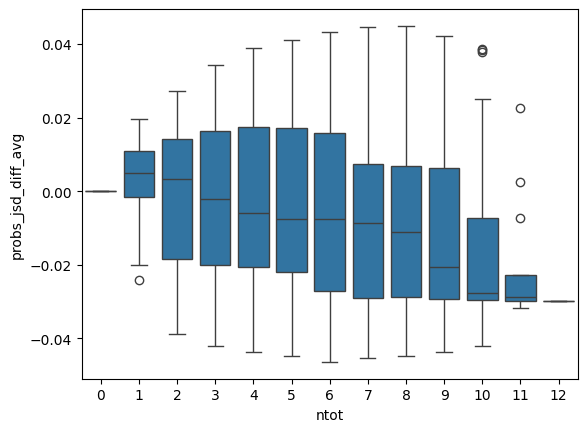

In [47]:
sns.boxplot(x='ntot',y='probs_jsd_diff_avg',data=all_mutated_sequences_df)

<Axes: xlabel='ntot', ylabel='log_probs_diff_abs_sum_avg'>

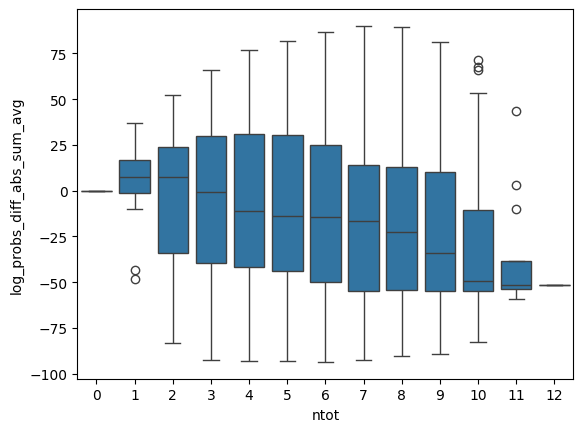

In [45]:
sns.boxplot(x='ntot',y='log_probs_diff_abs_sum_avg',data=all_mutated_sequences_df)

<Axes: xlabel='ntot', ylabel='log_probs_diff_abs_sum_avg'>

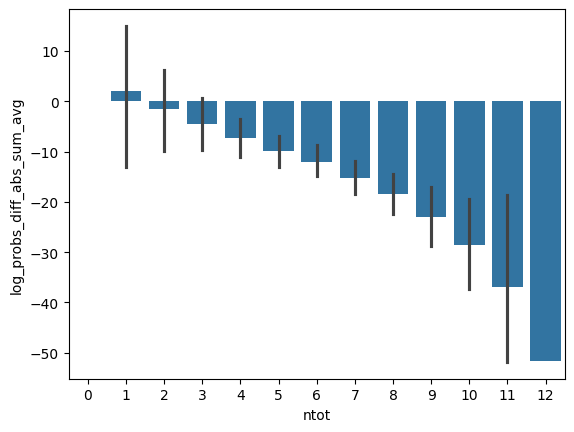

In [48]:
sns.barplot(x='ntot',y='log_probs_diff_abs_sum_avg',data=all_mutated_sequences_df)

<Axes: xlabel='ntot', ylabel='log_counts_diff_avg'>

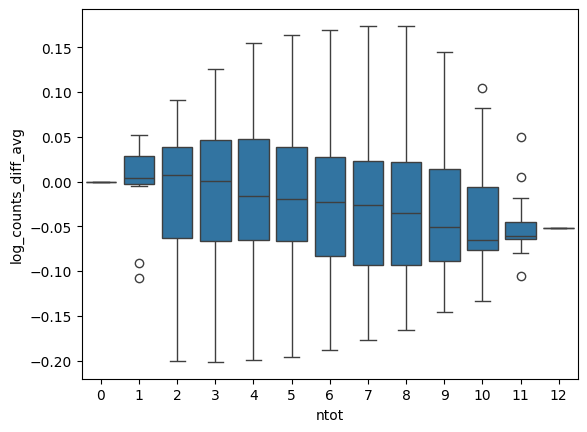

In [46]:
sns.boxplot(x='ntot',y='log_counts_diff_avg',data=all_mutated_sequences_df)

In [106]:
SNC_info['log_counts_diff'] = log_counts_diff
SNC_info['log_probs_diff_abs_sum'] = log_probs_diff_abs_sum
SNC_info['probs_jsd_diff'] = probs_jsd_diff


In [111]:
all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot']==1].sort_values(by='SNC')

,sequence_id,ntot,SNC,log_counts_diff,log_probs_diff_abs_sum,probs_jsd_diff
2048,2048,1,ID_0,0.057298,33.271660,0.016213
1024,1024,1,ID_1,-0.017077,-10.631042,-0.006652
2,2,1,ID_10,-0.001064,-10.502674,-0.008765
1,1,1,ID_11,0.007320,16.094421,0.011625
512,512,1,ID_2,-0.009942,-21.951031,-0.012019
256,256,1,ID_3,-0.153515,-36.468910,-0.016049
128,128,1,ID_4,0.023925,14.757605,0.009469
64,64,1,ID_5,0.067014,26.847120,0.015856
32,32,1,ID_6,-0.035574,-23.139273,-0.013443
16,16,1,ID_7,-0.093054,-30.242167,-0.015173


<Axes: xlabel='ntot', ylabel='log_counts_diff'>

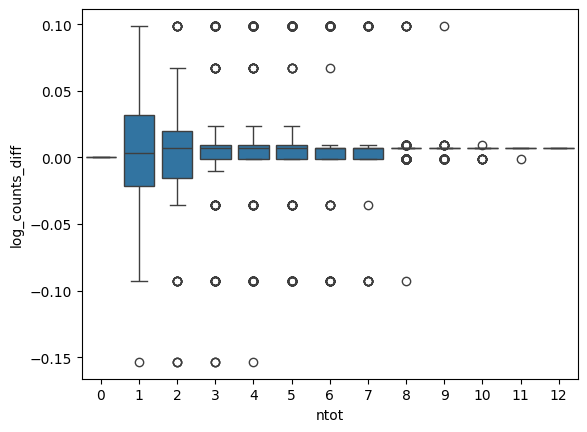

In [112]:
sns.boxplot(x='ntot',y='log_counts_diff',data=all_mutated_sequences_df)

In [27]:
len(all_mutated_sequences_ohe)

4096

In [28]:
len(all_mutated_sequences_ohe[0])

2114

In [30]:
all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot'].isin([0,12])]

,sequence_id,ntot,SNC
0,0,0,
4095,4095,12,ID_0_ID_1_ID_2_ID_3_ID_4_ID_5_ID_6_ID_7_ID_8_I...


In [34]:
all_mutated_sequences_ohe_extremes = np.array([all_mutated_sequences_ohe[0],all_mutated_sequences_ohe[4095]])

In [38]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    print(fold)
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

    results = interpret(model, all_mutated_sequences_ohe_extremes, 'SNC_SLC5A12_study_extr_'+fold, ['profile','counts'])

fold_0
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_1
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_2
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_3
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_4
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2

Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores


Seqs dimension : (1, 2114, 4)

Generating 'counts' shap scores
Done 0 examples of 1
Generating 'profile' shap scores
Done 0 examples of 1


In [28]:
results

{'profile': {'raw': {'seq': array([[[0, 1, 1, ..., 1, 0, 0],
           [0, 0, 0, ..., 0, 0, 1],
           [1, 0, 0, ..., 0, 1, 0],
           [0, 0, 0, ..., 0, 0, 0]]], dtype=int8)},
  'shap': {'seq': array([[[-0., -0.,  0., ...,  0., -0., -0.],
           [ 0., -0., -0., ..., -0., -0.,  0.],
           [ 0.,  0.,  0., ..., -0.,  0., -0.],
           [-0.,  0.,  0., ..., -0., -0., -0.]]], dtype=float16)},
  'projected_shap': {'seq': array([[[-0., -0.,  0., ...,  0., -0., -0.],
           [ 0., -0., -0., ..., -0., -0.,  0.],
           [ 0.,  0.,  0., ..., -0.,  0., -0.],
           [-0.,  0.,  0., ..., -0., -0., -0.]]], dtype=float16)}},
 'counts_scores': {'raw': {'seq': array([[[0, 1, 1, ..., 1, 0, 0],
           [0, 0, 0, ..., 0, 0, 1],
           [1, 0, 0, ..., 0, 1, 0],
           [0, 0, 0, ..., 0, 0, 0]]], dtype=int8)},
  'shap': {'seq': array([[[ 0.,  0., -0., ...,  0., -0., -0.],
           [ 0., -0.,  0., ..., -0., -0.,  0.],
           [ 0., -0., -0., ...,  0.,  0., -0.],
  